In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [2]:
bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )


In [3]:
from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()



In [4]:
import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260211-1755_2q_qst


In [5]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=True)
#session.disconnect()

[2026.02.11 18:03:24.562] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.11 18:03:24.564] INFO    VERSION: laboneq 25.10.3
[2026.02.11 18:03:24.564] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.11 18:03:24.565] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.11 18:03:24.567] INFO    Configuring the device setup
[2026.02.11 18:03:24.569] INFO    The device setup is configured


## 2Q QST Modules Overview

- `experiments.two_qubit_readout_calibration`: `|00>, |01>, |10>, |11>` 상태를 준비해 4x4 readout assignment matrix를 추정합니다.
- `experiments.two_qubit_state_tomography`: `ctrl/targ`를 `|+>`로 준비하고 bus에 고정 RIP를 적용한 뒤 9개 Pauli 설정(XX~ZZ)으로 측정합니다.
- `analysis.two_qubit_state_tomography`: assignment matrix를 포함한 noisy POVM + Cholesky MLE로 `rho`를 복원하고 metric/plot을 생성합니다.

아래 셀은 calibration -> tomography(+analysis) 순서로 실행하는 최소 예시입니다.

In [6]:
from experiments import two_qubit_state_tomography
from experiments import two_qubit_readout_calibration
from analysis.two_qubit_state_tomography import infer_bitflip_from_readout_calibration

# 2Q QST example run (RIP fixed-parameter mode)
ctrl = qubits[1]
targ = qubits[0]
bus = buses[0]
temporary_parameters = {}
c_temp_pars = deepcopy(ctrl.parameters)
t_temp_pars = deepcopy(targ.parameters)
b_temp_pars = deepcopy(bus.parameters)

temporary_parameters[ctrl.uid] = c_temp_pars
temporary_parameters[targ.uid] = t_temp_pars
temporary_parameters[bus.uid] = b_temp_pars

# 외부 readout calibration 실행
readout_cal_result = two_qubit_readout_calibration.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    temporary_parameters=temporary_parameters,
).run()

# calibration 결과로 qubit별 bitflip 자동 진단
bitflip_info = infer_bitflip_from_readout_calibration(
    readout_calibration_result=readout_cal_result,
    ctrl_uid=ctrl.uid,
    targ_uid=targ.uid,
)
bitflip_ctrl_auto = bool(bitflip_info["bitflip_ctrl"])
bitflip_targ_auto = bool(bitflip_info["bitflip_targ"])
print("auto bitflip ctrl/targ:", bitflip_ctrl_auto, bitflip_targ_auto)
print("ctrl acc direct/flip:", bitflip_info["accuracy_ctrl_direct"], bitflip_info["accuracy_ctrl_flip"])
print("targ acc direct/flip:", bitflip_info["accuracy_targ_direct"], bitflip_info["accuracy_targ_flip"])


[2026.02.11 18:03:24.592] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 18:03:24.592] INFO      Workflow 'two_qubit_readout_calibration': execution started at 2026-02-11     
[2026.02.11 18:03:24.593] INFO      09:03:24.591890Z                                                              
[2026.02.11 18:03:24.593] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 18:03:24.598] INFO    Task 'temporary_qpu': started at 2026-02-11 09:03:24.598749Z
[2026.02.11 18:03:24.599] INFO    Task 'temporary_qpu': ended at 2026-02-11 09:03:24.599835Z
[2026.02.11 18:03:24.603] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-11 
[2026.02.11 18:03:24.603] INFO    09:03:24.602441Z
[2026.02.11 18:03:24.605] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-11 09:03:24.605169Z
[2026.02.11 18:03:24.607] INFO    Task 'temporary_quantum_elements_from_qpu': started

bitflip applied ctrl/targ: False False
fidelity raw=0.2500, fixed=0.2500

Assignment matrix A (bitflip-adjusted) (rows=measured, cols=prepared):
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]]
Column sums (should be 1): [1. 1. 1. 1.]
Diagonal assignment probs: [0. 0. 0. 1.]
Average assignment fidelity: 0.25
Shots per prepared state: [4096 4096 4096 4096]


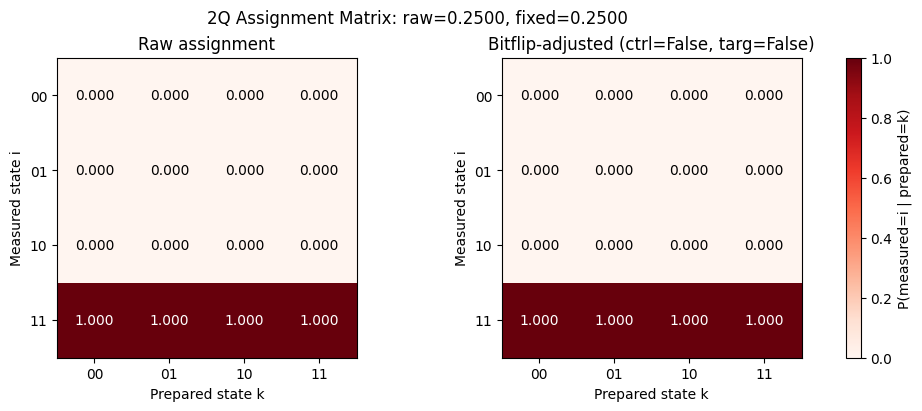

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from experiments.two_qubit_tomography_common import (
    READOUT_CALIBRATION_STATES,
    OUTCOME_LABELS,
    readout_calibration_handle,
)

def _unwrap_result_like(x):
    cur = x
    for _ in range(8):
        if hasattr(cur, "output"):
            cur = cur.output
            continue
        if isinstance(cur, dict):
            if "readout_calibration_result" in cur:
                cur = cur["readout_calibration_result"]
                continue
        return cur
    return cur

def _to_bits(arr):
    arr = np.asarray(arr).reshape(-1)
    return np.clip(np.rint(np.real(arr)).astype(int), 0, 1)

def build_assignment_matrix(readout_result, ctrl_uid, targ_uid, bitflip_ctrl=False, bitflip_targ=False):
    res = _unwrap_result_like(readout_result)
    counts = np.zeros((4, 4), dtype=int)  # rows: measured i, cols: prepared k

    for k, (prep_label, _states) in enumerate(READOUT_CALIBRATION_STATES):
        ctrl_bits = _to_bits(res[readout_calibration_handle(ctrl_uid, prep_label)].data)
        targ_bits = _to_bits(res[readout_calibration_handle(targ_uid, prep_label)].data)
        if bitflip_ctrl:
            ctrl_bits = 1 - ctrl_bits
        if bitflip_targ:
            targ_bits = 1 - targ_bits
        outcomes = 2 * ctrl_bits + targ_bits  # 00,01,10,11 -> 0,1,2,3
        counts[:, k] = np.bincount(outcomes, minlength=4)

    A = counts / np.maximum(counts.sum(axis=0, keepdims=True), 1)
    return A, counts

bitflip_ctrl = bool(globals().get("bitflip_ctrl_auto", False))
bitflip_targ = bool(globals().get("bitflip_targ_auto", False))

A_raw, C_raw = build_assignment_matrix(readout_cal_result, ctrl.uid, targ.uid, False, False)
A_fix, C_fix = build_assignment_matrix(readout_cal_result, ctrl.uid, targ.uid, bitflip_ctrl, bitflip_targ)

fid_raw = float(np.trace(A_raw) / 4.0)
fid_fix = float(np.trace(A_fix) / 4.0)
print("bitflip applied ctrl/targ:", bitflip_ctrl, bitflip_targ)
print(f"fidelity raw={fid_raw:.4f}, fixed={fid_fix:.4f}")

A = A_fix
C = C_fix
print("\nAssignment matrix A (bitflip-adjusted) (rows=measured, cols=prepared):")
print(np.array_str(A, precision=4, suppress_small=True))
print("Column sums (should be 1):", A.sum(axis=0))
print("Diagonal assignment probs:", np.diag(A))
print("Average assignment fidelity:", np.trace(A) / 4.0)
print("Shots per prepared state:", C.sum(axis=0))

assert np.allclose(A.sum(axis=0), 1.0, atol=1e-6), "Column sums are not ~1"

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
for ax, mat, title in [
    (axes[0], A_raw, "Raw assignment"),
    (axes[1], A_fix, f"Bitflip-adjusted (ctrl={bitflip_ctrl}, targ={bitflip_targ})"),
]:
    im = ax.imshow(mat, vmin=0, vmax=1, cmap="Reds")
    ax.set_title(title)
    ax.set_xlabel("Prepared state k")
    ax.set_ylabel("Measured state i")
    ax.set_xticks(range(4), OUTCOME_LABELS)
    ax.set_yticks(range(4), OUTCOME_LABELS)
    for i in range(4):
        for j in range(4):
            ax.text(j, i, f"{mat[i,j]:.3f}", ha="center", va="center",
                    color="white" if mat[i,j] > 0.6 else "black")

fig.colorbar(im, ax=axes.ravel().tolist(), label="P(measured=i | prepared=k)")
plt.suptitle(f"2Q Assignment Matrix: raw={fid_raw:.4f}, fixed={fid_fix:.4f}")
plt.show()


[2026.02.11 18:03:24.890] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 18:03:24.891] INFO      Workflow 'two_qubit_state_tomography': execution started at 2026-02-11        
[2026.02.11 18:03:24.891] INFO      09:03:24.890379Z                                                              
[2026.02.11 18:03:24.891] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 18:03:24.896] WARNING Type <class 'laboneq.workflow.result.WorkflowResult'> not supported by the serializer [name: two_qubit_state_tomography.input.readout_calibration_result].
[2026.02.11 18:03:24.903] INFO    Task 'temporary_qpu': started at 2026-02-11 09:03:24.903817Z
[2026.02.11 18:03:24.904] INFO    Task 'temporary_qpu': ended at 2026-02-11 09:03:24.904814Z
[2026.02.11 18:03:24.907] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-11 
[2026.02.11 18:03:24.907] INFO    09:03:24.907281Z
[2026.02.11

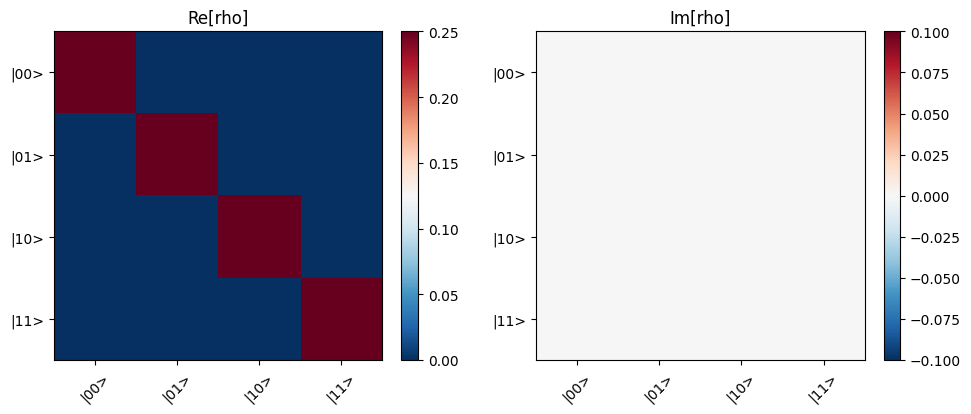

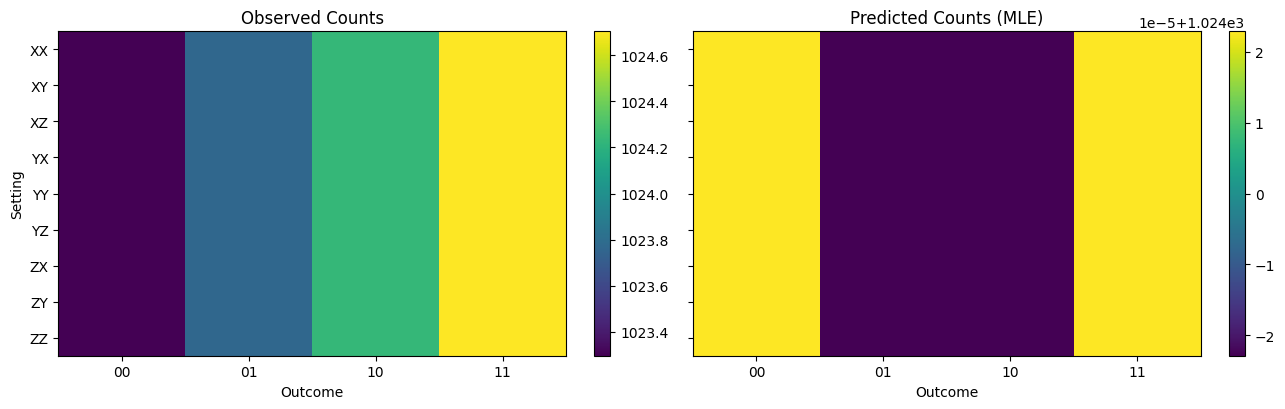

In [8]:
from experiments import two_qubit_state_tomography

tomo_options = two_qubit_state_tomography.experiment_workflow.options()
tomo_options.do_analysis(True)
tomo_options.do_readout_calibration(False)  # 외부 readout_cal_result 사용
tomo_options.auto_bitflip_from_calibration(True)  # calibration 결과로 ctrl/targ bitflip 자동 추정
# 수동 강제값을 쓰려면 아래처럼 설정하고 auto_bitflip_from_calibration(False)로 변경
# tomo_options.bitflip_ctrl(True)
# tomo_options.bitflip_targ(False)

bus_frequency = (
    bus.parameters.resonance_frequency_bus + (bus.parameters.rip_detuning or 0.0)
    if bus.parameters.resonance_frequency_bus is not None
    else 6.5e9
)
rip_amplitude = 0.0 #float(bus.parameters.rip_amplitude)
rip_length = 64e-9 #float(bus.parameters.rip_length)

twoq_qst_result = two_qubit_state_tomography.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    bus=bus,
    bus_frequency=bus_frequency,
    rip_amplitude=rip_amplitude,
    rip_length=rip_length,
    rip_phase=np.pi / 2,
    readout_calibration_result=readout_cal_result,
    target_state="++",
    options=tomo_options,
    temporary_parameters=temporary_parameters,
).run()

workflow_output = twoq_qst_result.output
analysis_output = workflow_output.get("analysis_result")
if hasattr(analysis_output, "output"):
    analysis_output = analysis_output.output

print("workflow keys:", list(workflow_output.keys()))
if isinstance(analysis_output, dict):
    print("analysis keys:", list(analysis_output.keys()))
    print("applied bitflip ctrl/targ:", analysis_output.get("bitflip_ctrl"), analysis_output.get("bitflip_targ"))
    print("metrics:")
    pprint(analysis_output.get("metrics", {}))


In [9]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=twoq_qst_result.tasks["compile_experiment"].output,name='test', interactive=True, max_events_to_publish=10000)
#plot_simulation(compiled_experiment=co_spec_result.tasks["compile_experiment"].output, length=250e-6)

[2026.02.11 18:03:25.387] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=10000` to bypass this step with a small impact on the compilation time.
[2026.02.11 18:03:25.391] INFO    Resolved modulation type of oscillator 'b0_drive_osc' on signal 'b0/drive' to HARDWARE
[2026.02.11 18:03:25.391] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal 'q0/acquire' to SOFTWARE
[2026.02.11 18:03:25.391] INFO    Resolved modulation type of oscillator 'q0_drive_ge_osc' on signal 'q0/drive' to HARDWARE
[2026.02.11 18:03:25.391] INFO    Resolved modulation type of oscillator 'q0_drive_ef_osc' on signal 'q0/drive_ef' to HARDWARE
[2026.02.11 18:03:25.392] INFO    Resolved modulation type of oscillator 'q1_readout_acquire_osc' on signal 'q1/acquire' to SOFTWARE
[2026.02.11 18:03:25.392] INFO    Resolved modulation type of oscillator 'q1_drive_ge_osc' on signal 'q1/dr

# SAVE QPU

In [10]:
# from laboneq.serializers import save, load, from_dict, from_json, to_dict, to_json
# import time

# t = time.localtime()
# timestamp = time.strftime('%Y%m%d-%H%M', t)

# filename = "2q_qst"
# save(qpu, filename=f"./qpu_parameters/{timestamp}_{filename}")



## 2Q QST Guideline Compliance (STEP-by-STEP)

아래는 `examples/selectiveRIP/2Q_quantum_state_tomography.md` 지침과 현재 구현 코드의 매핑입니다.

**STEP 1. 9개 측정 설정 $s$**

수식/개념:
$$
s \in \{XX,XY,XZ,YX,YY,YZ,ZX,ZY,ZZ\}
$$

코드:
- `experiments/two_qubit_tomography_common.py`의 `TOMOGRAPHY_SETTINGS`
- `experiments/two_qubit_state_tomography.py:create_experiment()` 루프에서 각 setting 실행
- basis pre-rotation은 `_apply_measurement_prerotation()`로 구현

**STEP 2. Assignment matrix $A_{ik}$ calibration**

수식:
$$
A_{ik}=\frac{c_i^{(k)}}{N^{(k)}},\qquad N^{(k)}=\sum_i c_i^{(k)}
$$

코드:
- 실험: `experiments/two_qubit_readout_calibration.py:create_experiment()`
  - 준비 상태: $|00\rangle,|01\rangle,|10\rangle,|11\rangle$
- 분석: `analysis/two_qubit_state_tomography.py:extract_assignment_matrix()`
  - `counts_matrix[:,k] / sum(counts_matrix[:,k])`

**STEP 3. Ideal POVM $E^{ideal}_{s,k}$**

수식:
$$
E^{\mathrm{ideal}}_{s,k}=U_s^\dagger\Pi_k U_s
$$

코드:
- `analysis/two_qubit_state_tomography.py:_computational_projectors_2q()`
- `analysis/two_qubit_state_tomography.py:_single_qubit_prerotation_unitary()`
- `analysis/two_qubit_state_tomography.py:_build_noisy_povm()` 내부에서 `ideal_povm` 생성

**STEP 4. Noisy POVM $E^{meas}_{s,i}$**

수식:
$$
E^{\mathrm{meas}}_{s,i}=\sum_k A_{ik}E^{\mathrm{ideal}}_{s,k}
$$

코드:
- `analysis/two_qubit_state_tomography.py:_build_noisy_povm()`
  - `e_meas += assignment_matrix[i,k] * ideal_povm[k]`

**STEP 5. 확률 모델 $p_{s,i}(\rho)$**

수식:
$$
p_{s,i}(\rho)=\mathrm{Tr}\left(E^{\mathrm{meas}}_{s,i}\rho\right)
$$

코드:
- `analysis/two_qubit_state_tomography.py:_predict_probabilities()`

**STEP 6. 로그우도 최대화(MLE)**

수식:
$$
\log L(\rho)=\sum_{s,i} n_{s,i}\log p_{s,i}(\rho),\qquad
\min -\log L
$$

코드:
- `analysis/two_qubit_state_tomography.py:maximum_likelihood_reconstruct()`
- objective: `-np.sum(counts * np.log(probs))`

**STEP 7. 물리적 상태 파라미터화(Cholesky)**

수식:
$$
\rho(\theta)=\frac{T(\theta)^\dagger T(\theta)}{\mathrm{Tr}(T(\theta)^\dagger T(\theta))}
$$

코드:
- `analysis/two_qubit_state_tomography.py:_theta_to_density_matrix()`
  - lower-triangular 복소 행렬 `T` 구성 후 `T^\dagger T` 정규화

**STEP 8. 검증/후처리**

코드:
- `analysis/two_qubit_state_tomography.py:calculate_state_metrics()`
  - trace, purity, min eigenvalue, Pauli correlators, target fidelity
- `plot_density_matrix()`, `plot_counts()`

**실험 시퀀스(요청사항 반영) 정합성**

현재 `experiments/two_qubit_state_tomography.py`에서 각 setting마다 순서가 아래처럼 강제됩니다:
$$
\text{prep} \rightarrow \text{RIP} \rightarrow \text{basis rotation} \rightarrow \text{measure}
$$

`play_after` 체인으로 겹침을 막도록 구현되어 있습니다.

**참고(지침 대비 구현 선택)**

- readout은 `AcquisitionType.DISCRIMINATION`을 사용해 bit outcome을 직접 수집하고, 이를 count $n_{s,i}$로 변환합니다.
- 기본 shot 수는 현재 설정상 4096(지침 예시 5k~20k보다 낮음)이며, 옵션으로 늘릴 수 있습니다.


## INTEGRATION Pipeline Validation (New)

아래 셀은 **DISCRIMINATION 경로 없이** `INTEGRATION + SINGLE_SHOT` 기반으로\n
`two_qubit_readout_calibration` -> `two_qubit_state_tomography` 분석이 동작하는지 검증합니다.


[2026.02.11 18:03:25.488] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 18:03:25.489] INFO      Workflow 'two_qubit_readout_calibration': execution started at 2026-02-11     
[2026.02.11 18:03:25.489] INFO      09:03:25.488596Z                                                              
[2026.02.11 18:03:25.490] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 18:03:25.495] INFO    Task 'temporary_qpu': started at 2026-02-11 09:03:25.495327Z
[2026.02.11 18:03:25.496] INFO    Task 'temporary_qpu': ended at 2026-02-11 09:03:25.496403Z
[2026.02.11 18:03:25.499] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-11 
[2026.02.11 18:03:25.500] INFO    09:03:25.499615Z
[2026.02.11 18:03:25.500] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-11 09:03:25.500543Z
[2026.02.11 18:03:25.502] INFO    Task 'temporary_quantum_elements_from_qpu': started

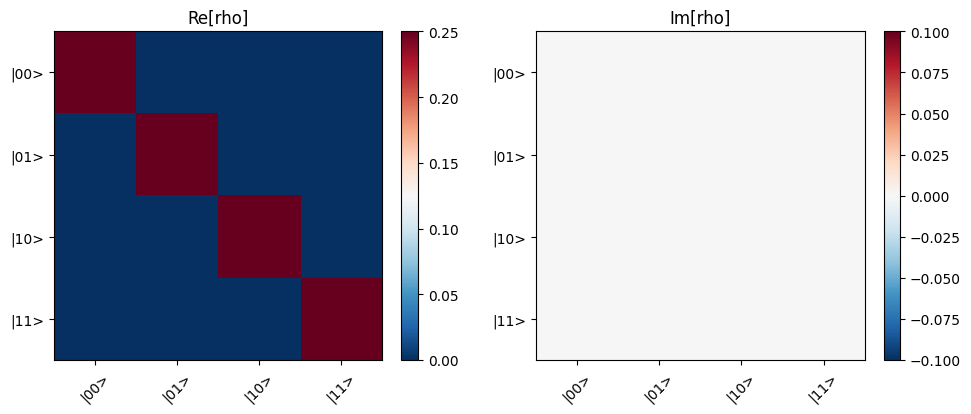

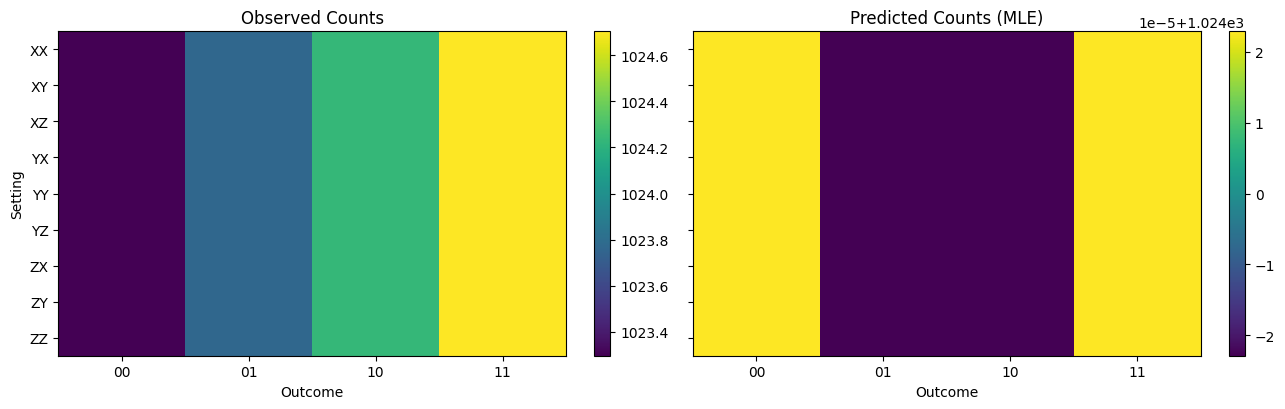

In [11]:
from experiments import two_qubit_readout_calibration
from experiments import two_qubit_state_tomography
import numpy as np

# Reuse existing variables from notebook: session, qpu, ctrl, targ, bus, temporary_parameters
if "ctrl" not in globals() or "targ" not in globals():
    ctrl = qubits[1]
    targ = qubits[0]
if "bus" not in globals():
    bus = buses[0]
if "temporary_parameters" not in globals():
    temporary_parameters = {}


def unwrap_output(obj):
    cur = obj
    for _ in range(24):
        if hasattr(cur, "output"):
            cur = cur.output
            continue
        return cur
    return cur


def _is_reference_like(obj):
    return obj is not None and obj.__class__.__name__ == "Reference"


def _contains_reference(obj, depth=0, max_depth=12):
    if depth > max_depth:
        return False
    cur = unwrap_output(obj)
    if _is_reference_like(cur):
        return True
    if isinstance(cur, dict):
        return any(_contains_reference(v, depth + 1, max_depth) for v in cur.values())
    if isinstance(cur, (list, tuple)):
        return any(_contains_reference(v, depth + 1, max_depth) for v in cur)
    return False


def _iter_tasks(node):
    tasks = getattr(node, "tasks", None)
    if tasks is None:
        return []
    try:
        return list(tasks)
    except Exception:
        return []


def _task_output(tasks, key):
    try:
        out = unwrap_output(tasks[key].output)
    except Exception:
        return None
    if _is_reference_like(out):
        return None
    return out


def _assemble_from_analysis_tasks(analysis_node):
    tasks = getattr(analysis_node, "tasks", None)
    if tasks is None:
        return None

    assignment = _task_output(tasks, "extract_assignment_matrix")
    tomography_counts = _task_output(tasks, "collect_tomography_counts")
    mle = _task_output(tasks, "maximum_likelihood_reconstruct")
    state_metrics = _task_output(tasks, "calculate_state_metrics")
    discriminator = _task_output(tasks, "fit_discriminator_from_readout_calibration")

    if not all(isinstance(x, dict) for x in [assignment, tomography_counts, mle, state_metrics, discriminator]):
        return None

    assembled = {
        "assignment_matrix": assignment.get("assignment_matrix"),
        "assignment_counts": assignment.get("counts_matrix_soft"),
        "assignment_counts_soft": assignment.get("counts_matrix_soft"),
        "assignment_counts_hard": assignment.get("counts_matrix_hard"),
        "tomography_counts": tomography_counts.get("counts"),
        "tomography_counts_hard": tomography_counts.get("counts_hard"),
        "setting_labels": tomography_counts.get("setting_labels"),
        "shots_per_setting": tomography_counts.get("shots_per_setting"),
        "rho_hat_real": mle.get("rho_hat_real"),
        "rho_hat_imag": mle.get("rho_hat_imag"),
        "predicted_probabilities": mle.get("predicted_probabilities"),
        "predicted_counts": mle.get("predicted_counts"),
        "optimizer_success": mle.get("optimizer_success"),
        "optimizer_message": mle.get("optimizer_message"),
        "negative_log_likelihood": mle.get("negative_log_likelihood"),
        "metrics": state_metrics,
        "discriminator_model": discriminator.get("model"),
        "classification_diagnostics": discriminator.get("diagnostics"),
        "bitflip_ctrl": False,
        "bitflip_targ": False,
    }
    return assembled


def _find_analysis_node(root, depth=0, max_depth=12):
    if root is None or depth > max_depth:
        return None
    tasks = _iter_tasks(root)
    if tasks:
        names = {getattr(t, "name", "") for t in tasks}
        if "maximum_likelihood_reconstruct" in names and "extract_assignment_matrix" in names:
            return root
        for t in tasks:
            found = _find_analysis_node(t, depth + 1, max_depth)
            if found is not None:
                return found
            found = _find_analysis_node(getattr(t, "output", None), depth + 1, max_depth)
            if found is not None:
                return found
    out = getattr(root, "output", None)
    if out is not None and out is not root:
        return _find_analysis_node(out, depth + 1, max_depth)
    return None


def extract_analysis_output(workflow_result):
    analysis_node = _find_analysis_node(workflow_result)
    if analysis_node is None:
        raise RuntimeError("Could not locate analysis workflow node.")

    out = unwrap_output(getattr(analysis_node, "output", None))
    if isinstance(out, dict) and not _contains_reference(out):
        return out

    assembled = _assemble_from_analysis_tasks(analysis_node)
    if isinstance(assembled, dict):
        return assembled

    raise RuntimeError("Could not materialize concrete analysis output from workflow tasks.")


# 1) Readout calibration acquisition (INTEGRATION + SINGLE_SHOT fixed by module)
readout_cal_result_new = two_qubit_readout_calibration.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    temporary_parameters=temporary_parameters,
).run()

# 2) 2Q tomography with external readout calibration result
tomo_opts_new = two_qubit_state_tomography.experiment_workflow.options()
tomo_opts_new.do_analysis(True)
tomo_opts_new.do_readout_calibration(False)

bus_frequency = (
    bus.parameters.resonance_frequency_bus + (bus.parameters.rip_detuning or 0.0)
    if bus.parameters.resonance_frequency_bus is not None
    else 6.5e9
)
rip_amplitude = float(getattr(bus.parameters, "rip_amplitude", 0.0) or 0.0)
rip_length = float(getattr(bus.parameters, "rip_length", 64e-9) or 64e-9)

twoq_qst_result_new = two_qubit_state_tomography.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    bus=bus,
    bus_frequency=bus_frequency,
    rip_amplitude=rip_amplitude,
    rip_length=rip_length,
    rip_phase=np.pi / 2,
    readout_calibration_result=readout_cal_result_new,
    target_state="++",
    options=tomo_opts_new,
    temporary_parameters=temporary_parameters,
).run()

out_new = unwrap_output(twoq_qst_result_new.output)
analysis_new = extract_analysis_output(twoq_qst_result_new)

print("top-level task names:", [t.name for t in twoq_qst_result_new.tasks])
print("workflow output type:", type(out_new).__name__)
print("analysis keys:", list(analysis_new.keys()))
print("fidelity_to_target:", analysis_new["metrics"].get("fidelity_to_target"))
print("classifier diagnostics:", analysis_new.get("classification_diagnostics", {}))



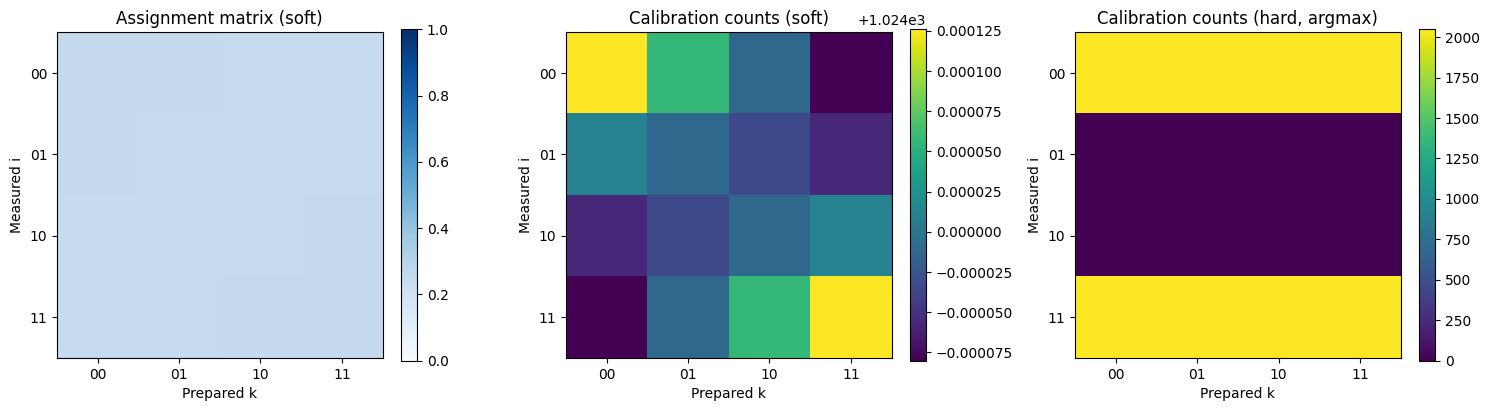

In [12]:
import matplotlib.pyplot as plt
import numpy as np

A_soft = np.asarray(analysis_new["assignment_matrix"], dtype=float)
C_soft = np.asarray(analysis_new["assignment_counts_soft"], dtype=float)
C_hard = np.asarray(analysis_new["assignment_counts_hard"], dtype=float)

fig, axes = plt.subplots(1, 3, figsize=(15, 4.2))

im0 = axes[0].imshow(A_soft, vmin=0.0, vmax=1.0, cmap="Blues")
axes[0].set_title("Assignment matrix (soft)")
axes[0].set_xlabel("Prepared k")
axes[0].set_ylabel("Measured i")
axes[0].set_xticks(range(4), ["00", "01", "10", "11"])
axes[0].set_yticks(range(4), ["00", "01", "10", "11"])
fig.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(C_soft, cmap="viridis")
axes[1].set_title("Calibration counts (soft)")
axes[1].set_xlabel("Prepared k")
axes[1].set_ylabel("Measured i")
axes[1].set_xticks(range(4), ["00", "01", "10", "11"])
axes[1].set_yticks(range(4), ["00", "01", "10", "11"])
fig.colorbar(im1, ax=axes[1], fraction=0.046)

im2 = axes[2].imshow(C_hard, cmap="viridis")
axes[2].set_title("Calibration counts (hard, argmax)")
axes[2].set_xlabel("Prepared k")
axes[2].set_ylabel("Measured i")
axes[2].set_xticks(range(4), ["00", "01", "10", "11"])
axes[2].set_yticks(range(4), ["00", "01", "10", "11"])
fig.colorbar(im2, ax=axes[2], fraction=0.046)

fig.tight_layout()
plt.show()
